In [1]:
# Import everything

import os

import numpy as np
import pandas as pd
import pytest

import copy as copy
import json
import networkx as nx
from power_grid_model.utils import json_deserialize, json_serialize
import power_system_simulation.graph_processing as pss
import power_system_simulation.pgm_processing as pgm_p
import power_system_simulation.optimization as psso

import os
import sys
import pytest

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation

import matplotlib

# Some graphics processing
import xml.etree.ElementTree as ET
from IPython.display import SVG, display, HTML
import matplotlib.pyplot as plt

import power_system_simulation.graph_processing as pss
import power_system_simulation.optimization as psso
from power_grid_model.utils import json_deserialize, json_serialize

import time
import re
import json
import pandas as pd

In [2]:
# Graph processing
    
red = '#f54040'
green = '#86fc53'
blue = '#1cd5ff'

svg_content = ''

def update_style(svg_code, element_id, new_style):
    pattern = f'(<[^>]+id="{element_id}"[^>]+style=")[^"]*(")'
    replacement = f''
    if "e" in element_id:
        replacement = f'\\1stroke:{new_style}\\2'
    elif "v" in element_id:
        replacement = f'\\1fill:{new_style}\\2'
        
    updated_svg_code = re.sub(pattern, replacement, svg_code)
    updated_svg_code = re.sub(f'(<[^>]+id="t{element_id}"[^>]+style=")[^"]*(")', f'\\1fill:{new_style}\\2', updated_svg_code)
        
    return updated_svg_code

def update():
    global svg_content
    style = "<style>svg{width:50px !important;height:50px !important;</style>"
    display(SVG(svg_content), clear=True)

def blink_edges(edge_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for edge in edge_ids:
            svg_content_a=update_style(svg_content_a, f'e{edge}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for edge in edge_ids:
            svg_content_b=update_style(svg_content_b, f'e{edge}', 'gray')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def blink_vertices(vertex_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for vertex in vertex_ids:
            svg_content_a=update_style(svg_content_a, f'v{vertex}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for vertex in vertex_ids:
            svg_content_b=update_style(svg_content_b, f'v{vertex}', 'white')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def highlight_disabled_edges(gp):
    global svg_content
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#f54040')
            update()
            
def visualizer_init(gp):
    global svg_content
    
    with open('Asset 1.svg', 'r') as file:
        svg_content = file.read()
    
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#303030')
    update()
            
def highlight_edge(edge_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'e{edge_id}', color)
    update()
    
def highlight_vertex(vertex_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'v{vertex_id}', color)
    update()
    
def visualizer_alternative_edge(gp, edge_id):
    highlight_edge(edge_id, red)
    alternative_edges = gp.find_alternative_edges(edge_id)
    for edge in alternative_edges:
        highlight_edge(edge, color=green)
    
def visualizer_downstream_vertices(gp, edge_id):
    highlight_edge(edge_id, red)
    downstream_vertices = gp.find_downstream_vertices(edge_id)
    for vertex in downstream_vertices:
        highlight_vertex(vertex, color=green)

# **Power Systems Calculation Package: Myriad**

Introduction
- Team Myriad
- Energy Transition
    - A future with less polution
    - Renewable energy sources
    - Electrical vehicles
    - Eeat pumps
- Uncertainties in the grid
    - Applying statistical methods and relevant data science techniques in the design and operation of the grid.
- Multidiciplinary profiles:
    - Electrical power engineering, data science, and scientific software engineering 
- Assignments 1, 2 and 3.

# **General Overview**

This package includes multiple types of functions, some of the important ones are:
- EV Penetration calculations
- Optimal tap position calculation
- Alternative edge searching
- Testing
- Teamwork

***

# **EV Penetration**

The main goal of this function is to randomly assign EV (electrical vehicle) charging profiles to houses that have a sym_load,
given a user-provided input for the penetration level. 

This can be done step-by-step, beginning with the conversion of the input data. This is done because the Downstream Vertices function from assignment 1 is also used for this function:

```python
# Make Graphprocessing instance to draw the graph
vertex_ids = [node[0] for node in self.pgm_input["node"]]
edge_ids = [edge[0] for edge in self.pgm_input["line"]]
edge_vertex_id_pairs = [(edge[1], edge[2]) for edge in self.pgm_input["line"]]
edge_enabled = [(edge[3] == 1 and edge[4] == 1) for edge in self.pgm_input["line"]]
source_vertex_id = self.pgm_input["source"][0][1]

# Pretend all transformers are short circuits, so that GraphProcessor can use it
for transformer in self.pgm_input["transformer"]:
    edge_vertex_id_pairs.append((transformer[1], transformer[2]))
    edge_enabled.append(True)
    edge_ids.append(transformer[0])
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Now that we have converted the given input data, we can initialize a graph processor object:

```python 
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Now the Downstream Vertices function from assignment 1 can be used to find which nodes belong to which LV feeders:

```python
# See which feeder has which nodes
        for feeder_id in self.meta_data["lv_feeders"]:
            feeders.append(feeder_id)
            feeder_nodes[feeder_id] = gp.find_downstream_vertices(feeder_id)
```
 
After finding which nodes belong to which LV feeders, the calculation can be shown in a couple of points:
- Calculating the amount of EV-houses per LV feeder
    - The amount of EV-houses per LV feeder is calculated using: ``math.floor(penetration_level * total_houses / total_feeders)`` in order to round down to the nearest intiger.
- Finding which of the nodes are houses for each LV feeder.
    - This is done by checking which node ID's match the ID's in sym_load from the input data and then assigning only those to their corresponding LV feeder.
- Randomly choose houses that will get an EV charger.
    - Using the random.sample function to assign multiple random profiles to houses, making sure that there are no repetitives.
- Assign random EV charging profiles to the chosen houses 
    - This time using the random.shuffle with a for loop was needed to randomly choose a profile for each house without repetitives.
- Assign sym_load nodes to input_network_data.json IDs
- Modify the active and reactive load profile according to the EV house profile
- Run a time-series power flow and return the two aggregation tables
    - Using the functions create_update_model, run_batch_process, and get_aggregate_results from Assignment 2 to print the tables as Dataframes.

## Downstream Vertices Algorithm Steps

- Remove the input edge from the id_pairs list
- Find the islands
- Check which remaining islands contain the source vertex, the other island is our output

Or in code form:
```python
# Create two islands by seperating the graph at the input edge
edge_list.remove(input_edge)

islands = calculate_islands()

for island in islands:
    if not island.contains(source_vertex):
        return island
```

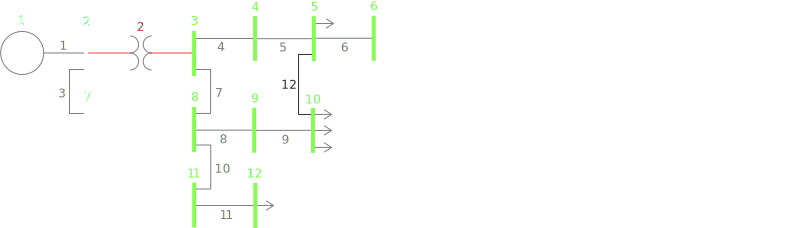

In [3]:
vertex_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_vertex_id_pairs = [
    (1, 2), (2, 3), (2, 7), (3, 4), (4, 5), (5, 6), (3, 8), (8, 9), (9, 10), (8, 11), (11, 12), (5, 10)
]
edge_enabled = [True, True, True, True, True, True, True, True, True, True, True, False]
source_vertex_id = 1

gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)

visualizer_init(gp)

visualizer_downstream_vertices(gp, 2)

***

# **Optimal tap position**

This section will detail the implementation of the optimal tap position search as well as the functionality implemented in assignment 2 for lower-level usage of the Power Grid Model package.

First, all the necessary data has to be imported. The functions take in the already-read data as an input, so it has to loaded before the creation the the class. The necessary data includes:
- The network description file, containing information on buses, lines, transformers, loads, and sources (.json PGM format)
- The active profile batch update set for symmetrical loads (.parquet)
- The reactive profile batch update set for symmetrical loads (.parquet)
- The active profile batch update data set for EV charging, containing various example 'profiles' of how an EV charger would behave in a power grid (.parquet)
- The meta data file (.json)

In [4]:
dir_meta_data_json = "presentation_A3/meta_data.json"
dir_network_json = "presentation_A3/input_network_data.json"
dir_active_profile = "presentation_A3/active_power_profile.parquet"
dir_reactive_profile = "presentation_A3/reactive_power_profile.parquet"
dir_ev_active_profile =  "presentation_A3/ev_active_power_profile.parquet"

with open(dir_meta_data_json) as fp:
    data = fp.read()
meta_data = json.loads(data)

with open(dir_network_json) as fp:
    data = fp.read()
network_data = json_deserialize(data)

active_profile = pd.read_parquet(dir_active_profile)
reactive_profile = pd.read_parquet(dir_reactive_profile)
ev_active_profile = pd.read_parquet(dir_ev_active_profile)

Afterwards, the LV Grid object is instantiated with the data. This is the only constructor of this class, and it performs all the necesasry checks for the corectedness of the data, which include graph description validity and update profile validity.

In [5]:
p = psso.LvGrid(network_data, active_profile, reactive_profile, ev_active_profile, meta_data)

The optimal tap position function can then be used directly. This method requires the user to specify either 'energy_loss' or 'voltage_deviation' as the evaluation criteria, which are the total energy loss of all lines over the whole period and the deviation of p.u. node voltages with respect to 1 p.u, respectively. In either case, the goal is to minimize the quantity.

The method returns a tuple, which contains the **node_id** to connect, and the calculated **quantity**.

*If a different criterion is provided, the result will be (-1, -1).*

In [6]:
p.optimal_tap_position("voltage_deviation")

(1, tuple[0.0750863213670021, 'min_tap'])

## Optimal tap position - process

The optimal tap position calculation can be rather slow. The general steps to find the optimal position for the given criteria are:
1. Set the "to" connection of the transformer to a valid tap position X
2. Change the Power Grid Model input to reflect the change of transformer connection
3. Create a **PgmProcessor** object.
4. Create the update models for the PgmProcessor object using **PgmProcessor.create_update_model()**
5. Run the batch power flow using **PgmProcessor.run_batch_process()**
6. Obtain the aggregated result tables from the calculation using **PgmProcessor.get_aggregate_results()**
7. Compare the desired quantity in the table to the best recorded value - update the best recorded value to the new one if it is better.
8. Repeat steps 1-7 for all other valid tap positions

### <u> PgmProcessor </u> 

The PgmProcessor class handles functionality related directly to the Power Grid Model package. In contrast, the graph processor handles fundamental graph-related methods, while LV_Grid is a high-level class for specific calculationns.

Similar to the constructor for the LV grid, the necessary data consists of the .json network description, active profile, and reactive profile. A validity check is performed again on the input data (It is redundant if used from within optimization, but this class can also be used standalone).

```python
processor = pgm_p.PgmProcessor(
    pgm_input, self.active_load_profile, self.reactive_load_profile
)
```

### <u> PgmProcessor.create_update_model() </u> 

This method is a wrapper around the creation of batch update data sets for power flow analysis. After some (possibly redundant) validity cheks are performed, the method creates them as such:
1. Create an *update array*. This update array is 3-dimensional and can be thought of as such:
 - Dimension 0 -> Each timestamp.
 - Dimension 1 -> (For each timestamp) Each symmetrical load.
 - Dimension 2 -> (For each timestamp and each symmetrical load) The instantenous active and reactive power at the node.
2. Fill the update array with appropriate data, according to the active and reactive update profiles
3. Create a *mutation dictionary*. This dictionary tells Power Grid Model that there is an *update array* for *sym_loads*.
4. Validate the batch mutation data.

```python
def create_update_model(
    self, use_active_load_profile: bool = None, use_reactive_load_profile: bool = None
) -> None:
    """
    Validates update data and creates the time-series batch mutations of active and reactive load profiles of network nodes for power-flow analysis.
    Args:
        use_active_load_profile: if specificed, a different active load profile can be used than the one the class was initialized with.
        use_reactive_load_profile: if specificed, a different active load profile can be used than the one the class was initialized with.
    Raises:
        ProfilesDontMatchError(0): if time series of both active and reactive profiles don't match
        ProfilesDontMatchError(1): if node IDs are not the same in either profile
        ProfilesDontMatchError(2): if node IDs are not the same in either profile, and in the Power Grid Model .json network description
    """
    use_active_load_profile = use_active_load_profile or self.active_load_profile
    use_reactive_load_profile = use_reactive_load_profile or self.reactive_load_profile

    # Check if time series of both active and reactive profile match
    if not use_active_load_profile.index.equals(use_reactive_load_profile.index):
        raise ProfilesDontMatchError(0)

    # Check if node IDs match in both profiles
    if not use_active_load_profile.columns.equals(use_reactive_load_profile.columns):
        raise ProfilesDontMatchError(1)

    # Check if node IDs in both profiles match the node IDs in the PGM JSON input descriptor
    if not np.array_equal(
        pd.DataFrame(self.pgm_input["sym_load"]).loc[:, "id"].to_numpy(),
        use_active_load_profile.columns.to_numpy(),
    ):
        raise ProfilesDontMatchError(2)

    # Validated, take any
    self.update_index_length = use_active_load_profile.index.shape[0]
    self.update_ids = use_active_load_profile.columns.to_numpy()

    self.update_load_profile = pgm.initialize_array(
        "update", "sym_load", (self.update_index_length, self.update_ids.shape[0])
    )
    self.update_load_profile["id"] = self.update_ids
    self.update_load_profile["p_specified"] = use_active_load_profile
    self.update_load_profile["q_specified"] = use_reactive_load_profile
    self.update_load_profile["status"] = 1

    self.time_series_mutation = {"sym_load": self.update_load_profile}
    pgm.validation.assert_valid_batch_data(
        input_data=self.pgm_input,
        update_data=self.time_series_mutation,
        calculation_type=pgm.CalculationType.power_flow,
    )
```

### <u> PgmProcessor.run_batch_process() </u> 

This simple method runs the batch power flow calculation on the network with the previously-created mutation dictionary.

```python
def run_batch_process(self) -> None:
    """
    Run the batch process on the input data according to the load update profile. Results are stored in a class variable.
    """
    self.output_data = self.pgm_model.calculate_power_flow(
        update_data=self.time_series_mutation,
        calculation_method=CalculationMethod.newton_raphson,
    )
```

### <u> PgmProcessor.get_aggregate_results() </u> 

This method returns the two aggregate tables, formatted to Pandas Dataframes and merged into a list. These are:
- (Index 0 in return list): A table with each row representing a timestamp, with the following columns:
    - Timestamp (index column)
    - Maximum p.u. voltage of all the nodes for this timestamp
    - The node ID with the maximum p.u. voltage
    - Minimum p.u. voltage of all the nodes for this timestamp
    - The node ID with the minimum p.u. voltage

- (Index 1 in return list): A table with each row representing a line, with the following columns:
    - Line ID (index column)
    - Energy loss of the line across the timeline in kWh 
    - Maximum loading in p.u. of the line across the whole timeline
    - Timestamp of this maximum loading moment
    - Minimum loading in p.u. of the line across the whole timeline
    - Timestamp of this minimum loading moment

This data is extracted from the `self.output_data` calculated in the previous method. The total power loss is calculated using a trapezoidal integral.

```python
def get_aggregate_results(self) -> list[pd.DataFrame, pd.DataFrame]:
    """
    Generate the two required output tables based on the variables created in run_batch_process.
    Returns:
        2-element list of data frames for the 2 required aggregated tables
    """
    # Initialize output variable
    aggregate_results = [None, None]

    # Make a list of all timestamps for later use
    list_of_timestamps = self.active_load_profile.index.strftime("%Y-%m-%d %H:%M:%S").to_list()

    # Output dataframe for the first required table
    df_min_max_nodes = pd.DataFrame()

    # Loop through all timestamps, and pick the nodes with minimum and maximum voltage
    for index, snapshot in enumerate(self.output_data["node"]):

        # Temporary dataframe which contains the timestamp snapshot data
        df = pd.DataFrame(snapshot)

        # Find the index of the row with the minimum and maximum value in the 'u_pu' column
        max_index = df["u_pu"].idxmax()
        min_index = df["u_pu"].idxmin()

        # Retrieve the row with the minimum and maximum value in the 'u_pu' column
        max_row = df.loc[max_index]
        min_row = df.loc[min_index]

        # Put the data in the correct rows, and columns
        df_min_max_nodes.loc[list_of_timestamps[index], "Max_Voltage_Node"] = max_row["id"]
        df_min_max_nodes.loc[list_of_timestamps[index], "Max_Voltage"] = max_row["u_pu"]
        df_min_max_nodes.loc[list_of_timestamps[index], "Min_Voltage_Node"] = min_row["id"]
        df_min_max_nodes.loc[list_of_timestamps[index], "Min_Voltage"] = min_row["u_pu"]

    aggregate_results[0] = df_min_max_nodes

    # Make a list with all the timestamp snapshots, to be used to find the max and min
    flattened_list = [tuple for sublist in self.output_data["line"] for tuple in sublist]
    data = [
        {"id": tpl[0], "energized": tpl[1], "loading": tpl[2], "p_from": tpl[3], "p_to": tpl[7]}
        for tpl in flattened_list
    ]

    # Output dataframe for the second required output table
    df_line_loss = pd.DataFrame()

    df = pd.DataFrame(data)

    # Number of unique lines
    num_nodes = df["id"].nunique()
    repeated_list_of_timestamps = [
        elem for elem in list_of_timestamps for _ in range(num_nodes)
    ]

    # Add timestamp column to dataframe
    df["Timestamp"] = repeated_list_of_timestamps

    # Group data by each line and then loop over each dataframe 'group'
    grouped_by_line = df.groupby("id")

    for line_id, line in grouped_by_line:
        line["p_loss"] = abs(abs(line["p_from"]) - abs(line["p_to"]))

        # Calculate the area under the power loss curve
        energy_loss = integrate.trapezoid(line["p_loss"].to_list()) / 1000

        # Find the index of the row with the minimum and maximum value in the 'u_pu' column
        max_index = line["loading"].idxmax()
        min_index = line["loading"].idxmin()

        # Retrieve the row with the minimum and maximum value in the 'u_pu' column
        max_row = line.loc[max_index]
        min_row = line.loc[min_index]

        # Put the data in the correct rows, and columns
        df_line_loss.loc[line_id, "Total_Loss"] = energy_loss
        df_line_loss.loc[line_id, "Max_Loading_Timestamp"] = max_row["Timestamp"]
        df_line_loss.loc[line_id, "Max_Loading"] = max_row["loading"]
        df_line_loss.loc[line_id, "Min_Loading_Timestamp"] = min_row["Timestamp"]
        df_line_loss.loc[line_id, "Min_Loading"] = min_row["loading"]

    aggregate_results[1] = df_line_loss
    aggregate_results[1].index.name = "Line_ID"
    aggregate_results[0].index = pd.to_datetime(aggregate_results[0].index)
    aggregate_results[0].index.name = "Timestamp"

    return aggregate_results
```

## * PgmProcessor - validation

### * <u> PgmProcessor.compare_to_expected(...) </u>

This method is not used for the optimal tap position or EV charging, but it is used to verify that the aggregate tables are equal to what is expected. Example usage - as no errors occur, the calculated output is equal to the expected output.

In [ ]:
# Load data
dir_network_json = "presentation_A2/input_network_data.json"
dir_active_profile = "presentation_A2/active_power_profile.parquet"
dir_reactive_profile = "presentation_A2/reactive_power_profile.parquet"

with open(dir_network_json) as fp:
    data = fp.read()
network_data = json_deserialize(data)

active_profile = pd.read_parquet(dir_active_profile)
reactive_profile = pd.read_parquet(dir_reactive_profile)

# Run data and get results
p = pgm_p.PgmProcessor(network_data, active_profile, reactive_profile)
p.create_update_model()
p.run_batch_process()
aggregate_results = p.get_aggregate_results()

# Save aggregate result
aggregate_results[0].to_parquet("presentation_A2/calculated_output_per_timestamp.parquet")
aggregate_results[1].to_parquet("presentation_A2/calculated_output_per_line.parquet")


# Test if pre-calculated output data matches the aggregated output
dir_out_per_line = "presentation_A2/output_table_row_per_line.parquet"
dir_out_per_timestamp = "presentation_A2/output_table_row_per_timestamp.parquet"

assert (
    p.compare_to_expected(
        aggregate_results,
        pd.read_parquet(dir_out_per_line),
        pd.read_parquet(dir_out_per_timestamp),
    )
    == True
)

# Change the output data and check if the error is detected
with pytest.raises(AssertionError) as excinfo:
    assert (
        p.compare_to_expected(
            aggregate_results,
            pd.read_parquet(dir_out_per_line),
            pd.read_parquet(dir_out_per_line),
        )
        == True
    )

## Optimal tap position - visualization

Both the aggregated data and raw output data from the batch power flow analysis can be visualized. The following options are available, with more being possible and easy to implement as needed due to the flexibility of the created framework:
1. Animated
    - Power flow - shows the **loading** of lines and symmetrical loads, as well as node **voltages** at each time stamp over time
    - Load records - shows the highest and lowest symmetrical load **voltages** at each time stamp over time - similar to the general power flow one, but easier to pinpoint locations of interest
    *(animations are exported in .gif format and opened externally)*
    *(the number of frames can be specified, or frames=PgmProcessor.draw_aggregate_table[(0 or 1)].index.size can be used)*
2. Static
    - Line loading - shows either the **total loss**, **maximum loading**, or **minimum loading** for each line at each time stamp over time
    - Node active power - plots the active power at the specified node over time in a line plot

In [ ]:
dir_meta_data_json = "presentation_A3/meta_data.json"
dir_network_json = "presentation_A3/input_network_data.json"
dir_active_profile = "presentation_A3/active_power_profile.parquet"
dir_reactive_profile = "presentation_A3/reactive_power_profile.parquet"
dir_ev_active_profile =  "presentation_A3/ev_active_power_profile.parquet"

with open(dir_meta_data_json) as fp:
    data = fp.read()
meta_data = json.loads(data)

with open(dir_network_json) as fp:
    data = fp.read()
network_data = json_deserialize(data)

active_profile = pd.read_parquet(dir_active_profile)
reactive_profile = pd.read_parquet(dir_reactive_profile)
ev_active_profile = pd.read_parquet(dir_ev_active_profile)

A) **General power flow for a network (limited to 10 frames)**

In [ ]:
p = pgm_p.PgmProcessor(network_data, active_profile, reactive_profile)
p.create_update_model()
p.run_batch_process()
aggregate_results = p.get_aggregate_results()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)
p.draw_init_power_flow('u_pu')

animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_power_flow, init_func=p.draw_init, frames=10, interval=250, blit=False)
animation.save("vis_A.gif", writer='Pillow', dpi=100)

B) **Aggregate per-load results from EV penetration**

In [ ]:
lv = psso.LV_grid(network_data, active_profile, reactive_profile, ev_active_profile, meta_data)
aggregate_results = lv.EV_penetration_level(0.8, False)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.55, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)

animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_node_loading, init_func=p.draw_init, frames=10, interval=250, blit=False)
animation.save("vis_B.gif", writer='Pillow', dpi=100)

C) **Static line-loading**
This method uses the aggregate data from draw_to_networkx(aggregate_results, ax)

In [ ]:
aggregate_results = p.get_aggregate_results()
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.55, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)
p.draw_static_line_loading('power_loss')

In [ ]:
aggregate_results = p.get_aggregate_results()
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.55, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)
p.draw_static_line_loading('max_loading')

In [ ]:
aggregate_results = p.get_aggregate_results()
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.55, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)
p.draw_static_line_loading('min_loading')

D) **Drawing a single EV load quantity (for example - and what is used - active power on node)**

In [ ]:
aggregate_results = lv.EV_penetration_level(0.8, False)

fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.55, bottom=0.1, top=0.9)

lv.processor.draw_static_simple_load_active(lv.processor.output_data, list(lv.House_Profile_Id.keys())[0], ax)

# **N-1 Calculation: Alternative grid topology**

In this function an edge is disconnected. The goal is to find a table where different alternative edges can be compared. 
For this, a conversion of the input data is required. This way, the functions made in Assignment 1 can be used:
```python 
vertex_ids = [node[0] for node in self.pgm_input["node"]]
edge_ids = [edge[0] for edge in self.pgm_input["line"]]
edge_vertex_id_pairs = [(edge[1], edge[2]) for edge in self.pgm_input["line"]]
edge_enabled = [(edge[3] == 1 and edge[4] == 1) for edge in self.pgm_input["line"]]
source_vertex_id = self.pgm_input["source"][0][1]
``` 
In this assignment we also have transformers. For the purpose of this function, these will be considered as normal edges and will be added to the edge_ids list:
```python 
for transformer in self.pgm_input["transformer"]:
    edge_ids.append(transformer)
```
# Using the graph processor
Now that we have converted the given input data, we can initialize a graph processor object:
```python 
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Using the object, we are now able to call: 
```python 
gp.find_alternative_edges(line_id)
```
The function above was written for Assignment 1.
For now we know that this function returns a list of all alternative edges. A more in depth explanation will be given shortly.
A constraint of the power system is that: 
```python
"6. The graph should be fully connected."
```
If we would disable an edge, the function looks for all alternative edges it can enable to have the system be fully connected again, thus following the mentioned contraint of the system. 
The function returns a list. For each alternative edge in that list, N-1 calculation will do as the name suggest, calculations. This is done using functions created in assignment 2. Since these have already been explained. A better way to finish this explanation is to tell what we do with the output of those functions.
We give each alternative edge a row with:
- The alternative Line ID to be connected
- The maximum loading in Watt among all lines and timestamps
- The Line ID of this maximum
- The timestamp of this maximum

Multiple alternative edges means that the table will consist of multiple rows. No alternative edges means that there are no rows in the table and thus having an empty one.

## Alternative Edge Algorithm Steps

- Get a list of all the disabled edges
- Loop through the list of disabled edges, and one by one enable each disabled edge
- Check if the graph is fully connected and non-circular
- If it is, add it to the list of alternative edges

Or in code form:
```python
alternative_edges = []
disabled_edge_list = []

edge_list.disable_edge(input_edge)

for edge in edge_list:
    if is_disabled(edge) is True:
        disabled_edge_list.append(edge)

for edge in disabled_edge_list:
    # Temporarily enable edge
    edge_list.enable_edge(edge)

    if not graph.isCyclic() and graph.isFullyConnected():
        alternative_edges.append(edge)
```

In [ ]:
visualizer_init(gp)

visualizer_alternative_edge(gp, 5)

***

# **Testing**

Testing the functions was done seperately between the assignments. In the very first assignment the downstream vertices and alternative edges functions are tested, also including some important errors. 

What basically has been done is that certain test cases are written in which the code should raise an error. For example when we check if all edges are unique, we make a case where this is not valid:

```python
# Non-unique edge-ID
t_edge_ids = [1, 3, 5, 7, 8, 8]
with pytest.raises(pss.IDNotUniqueError, match=r".*T1"):
    pss.GraphProcessor(
        vertex_ids, t_edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
    )
```
And the same was done for all the other errors, but also for the two functions. These two functions are done differently however; 
We create graphs and compare the functions output with the intended output of what the functions are supposed to give. For example a case for alternative edges is tested like this:

```python
def test_alternative_edges():
    # Graph being made for the testing of this function 
    vertex_ids = [0, 2, 4, 6, 10]
    edge_ids = [1, 3, 5, 7, 8, 9]
    edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
    edge_enabled = [True, True, True, False, False, True]
    source_vertex_id = 0

    gp = pss.GraphProcessor(
        vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
    )
    # When the functions is called, the alternative edge it should
    # give is edge 7 when edge 1 is being disabled
    assert set(gp.find_alternative_edges(1)) == set([7])
```
The graph that is being made looks like this:
```python
# vertex_0 (source) --edge_1(enabled)-- vertex_2 --edge_9(enabled)-- vertex_10
#                  |                               |
#                  |                           edge_7(disabled)
#                  |                               |
#                  -----------edge_3(enabled)-- vertex_4
#                  |                               |
#                  |                           edge_8(disabled)
#                  |                               |
#                  -----------edge_5(enabled)-- vertex_6
```
When the intended results match the results that is provided by our function reconfirms that the functions are working as intended.

For assignment 2 the same thing was done with the errors, but the functions are different. What now is done is that the results of the tables are being compared with the provided results of the given data. Here is and example of an error where there is a mismatch in timestamps:
```python
# Change a timestamp in active profile to an incorrect one and check for error
active_load_profile_wrong = active_load_profile.copy()
active_load_profile_wrong.rename(
    index={active_load_profile.index[0]: pd.to_datetime("today").normalize()}, inplace=True
)
with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T0") as excinfo:
    p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
    p.create_update_model()
```
Below is also something similar as assignment 1, but now the resulting tables are being compared to the provided tables of the data:

```python
assert (
    p.compare_to_expected(
        aggregate_results,
        pd.read_parquet(dir_out_per_line),
        pd.read_parquet(dir_out_per_timestamp),
    )
    == True
)
# Change the output data and check if the error is detected
with pytest.raises(AssertionError) as excinfo:
    assert (
        p.compare_to_expected(
            aggregate_results,
            pd.read_parquet(dir_out_per_line),
            pd.read_parquet(dir_out_per_line),
        )
        == True
    )
```

The testing of assignment 3 is a combination of the already existing classes and functions. 
The input data is checked for multiple different types of errors to make sure that the data is valid.
An example for this is the error check below:
```python
# 10 The number of EV charging profile is at least the same as the number of sym_load.
test_number_EV = copy.deepcopy(ev_active_profile)
new_column = copy.deepcopy(test_number_EV[1])
test_number_EV[4] = new_column
with pytest.raises(psso.EvProfilesDontMatchSymLoad) as excinfo:
    psso.LV_grid(network_data, active_profile, reactive_profile, test_number_EV, meta_data)
```
It is practically done the same as in assignment 1 and 2, but here the input data is altered to where it should give an error.
Furthermore, the testing of the functions are kind of already done in the previous assignments so it was not necessarily needed to test them again, except for the optimal tap postition. In the optimal tap position the calculated position is compared with the intended position to see whether the function is working as intended.
***


# **Conclusion**

***

## **Teamwork**

Someone?: [Explain how we worked together, using github and regular meetings and stuff, maybe planning etc]

***

### * <u> Drawing a large network </u>
This illustrates how such a large network would look like.

In [ ]:
dir_meta_data_json = "D:/presentation_large/meta_data.json"
dir_network_json = "D:/presentation_large/input_network_data.json"
dir_active_profile = "D:/presentation_large/active_power_profile.parquet"
dir_reactive_profile = "D:/presentation_large/reactive_power_profile.parquet"
dir_ev_active_profile =  "D:/presentation_large/ev_active_power_profile.parquet"

with open(dir_meta_data_json) as fp:
    data = fp.read()
meta_data = json.loads(data)

with open(dir_network_json) as fp:
    data = fp.read()
network_data = json_deserialize(data)

active_profile = pd.read_parquet(dir_active_profile)
reactive_profile = pd.read_parquet(dir_reactive_profile)
ev_active_profile = pd.read_parquet(dir_ev_active_profile)

p = pgm_p.PgmProcessor(network_data, active_profile, reactive_profile)
p.create_update_model()
p.run_batch_process()
aggregate_results = p.get_aggregate_results()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

p.draw_to_networkx(aggregate_results, ax)
p.draw_init_power_flow('u_pu')

animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_power_flow, init_func=p.draw_init, frames=10, interval=250, blit=False)
animation.save("vis_large.gif", writer='Pillow', dpi=100)